In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

from lifelines.datasets import load_waltons
df = load_waltons() 

In [2]:
df['group'].unique()

array(['miR-137', 'control'], dtype=object)

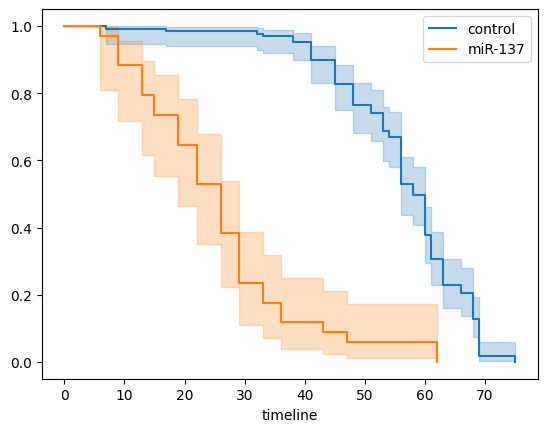

In [3]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
group_dfs = []
for name, grouped_df in df.groupby('group'):
    group_dfs.append(grouped_df)
    kmf.fit(grouped_df['T'], grouped_df['E'], label=name)
    kmf.plot_survival_function()

In [4]:
from lifelines.statistics import logrank_test, multivariate_logrank_test

t0 = 20
res = logrank_test(
    group_dfs[0]["T"], 
    group_dfs[1]["T"],
    group_dfs[0]["E"],
    group_dfs[1]["E"],
    t_0=t0
)
res.test_statistic

41.8595583505775

In [5]:
Nij = [[], []]
Oij = [[], []]
for i in range(2):
    gdf = group_dfs[i]
    for j in range(t0+1):
        Nij[i].append(gdf.loc[gdf['T'] >= j].shape[0])
        # Oij[i].append(gdf.loc[(gdf['T'] < j + 1e-5) & gdf['E']].shape[0])
        Oij[i].append(gdf.loc[(np.abs(gdf['T'] - j) < 1e-5) & gdf['E']].shape[0])
Nij = np.array(Nij)
Oij = np.array(Oij)
Nj = Nij.sum(axis=0)
Oj = Oij.sum(axis=0)
Eij = Nij * (Oj / Nj)
Vij = Eij * ((Nj - Oj) / Nj) * ((Nj - Nij) / (Nj - 1))
test_stat = np.sum(Oij - Eij, axis=1) ** 2 / np.sum(Vij, axis=1)
test_stat[0]

41.85955835057754

In [6]:
import scipy.stats
rvs = scipy.stats.expon.rvs(size=(10, 2))
control_rvs = rvs[:,0] 
hazard_ratio = 0.7
treatment_rvs = rvs[:,1] / hazard_ratio

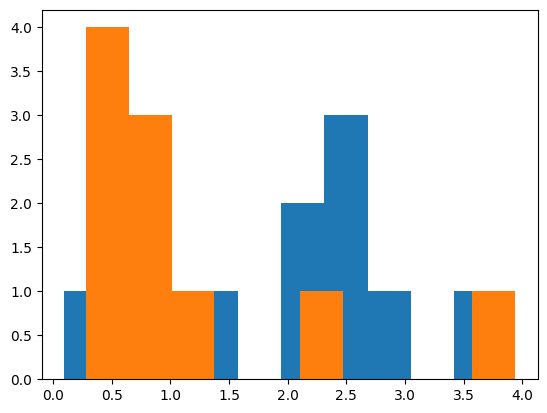

In [7]:
plt.hist(treatment_rvs)
plt.hist(control_rvs)
plt.show()

In [8]:
censoring_time = 4
all_rvs = np.concatenate([control_rvs, treatment_rvs])
group = np.concatenate([np.zeros(control_rvs.shape[0]), np.ones(treatment_rvs.shape[0])]).astype(bool)

In [9]:
ordering = np.argsort(all_rvs)
ordered_group = group[ordering]
ordered = all_rvs[ordering]
Nij = [[], []]
Oij = [[], []]
events_so_far = [0, 0]
max_idx = np.argmin(ordered <= censoring_time)
for j in range(max_idx):
    for i in range(2):
        event_now = ordered_group[j] == (i == 1)
        Nij[i].append(rvs.shape[0] - events_so_far[i])
        Oij[i].append(event_now)
        events_so_far[i] += event_now
Nij = np.array(Nij)
Oij = np.array(Oij)
Nj = Nij.sum(axis=0)
Oj = Oij.sum(axis=0)
Eij = Nij * (Oj / Nj)
Vij = Eij * ((Nj - Oj) / Nj) * ((Nj - Nij) / (Nj - 1))
test_stat = np.sum(Oij - Eij, axis=1) ** 2 / np.sum(Vij, axis=1)
test_stat[0]

nan

In [10]:
multivariate_logrank_test(ordered, ordered_group, t0=4).test_statistic

1.1327114775815934

In [11]:
all_rvs

array([1.06299291, 0.92055381, 2.3472681 , 3.94064745, 0.55748139,
       0.27605243, 0.55676587, 0.69186709, 0.53860309, 0.90666933,
       1.40185692, 0.09397955, 2.18559547, 2.65171348, 0.46576428,
       2.38759256, 2.06473884, 3.79261144, 2.41375632, 2.77593824])

In [12]:
ordering = jnp.argsort(all_rvs)
ordered = all_rvs[ordering]
ordered_group = group[ordering]
max_idx = jnp.argmin(ordered <= censoring_time)
if max_idx == 0 and jnp.all(ordered <= censoring_time):
    max_idx = ordered.shape[0]
event_now = jnp.stack((~ordered_group, ordered_group), axis=0) * (
    jnp.arange(ordered.shape[0]) < max_idx
)
events_so_far = jnp.concatenate(
    (jnp.zeros((2, 1)), event_now.cumsum(axis=1)[:, :-1]), axis=1
)
Nij = rvs.shape[0] - events_so_far
Oij = event_now
Nj = Nij.sum(axis=0)
Oj = Oij.sum(axis=0)
Eij = Nij * (Oj / Nj)
Vij = Eij * ((Nj - Oj) / Nj) * ((Nj - Nij) / (Nj - 1))
denom = jnp.sum(jnp.where(~jnp.isnan(Vij[0]), Vij[0], 0), axis=0)
test_stat = jnp.sum(Oij[0] - Eij[0], axis=0) ** 2 / denom

In [13]:
test_stat

DeviceArray(1.1327114, dtype=float32)

In [15]:
@jax.jit
def logrank_test(all_rvs, group, censoring_time):
    n = all_rvs.shape[0]
    ordering = jnp.argsort(all_rvs)
    ordered = all_rvs[ordering]
    ordered_group = group[ordering]
    include = ordered <= censoring_time
    event_now = jnp.stack((~ordered_group, ordered_group), axis=0) * include
    events_so_far = jnp.concatenate(
        (jnp.zeros((2, 1)), event_now.cumsum(axis=1)[:, :-1]), axis=1
    )
    Nij = n - events_so_far
    Oij = event_now
    Nj = Nij.sum(axis=0)
    Oj = Oij.sum(axis=0)
    Eij = Nij * (Oj / Nj)
    Vij = Eij * ((Nj - Oj) / Nj) * ((Nj - Nij) / (Nj - 1))
    denom = jnp.sum(jnp.where(~jnp.isnan(Vij[0]), Vij[0], 0), axis=0)
    # return jnp.sum(Oij[0] - Eij[0], axis=0) / jnp.sqrt(denom)
    # To match with the lifelines implementation, we square everything. This is
    # a weird because it means that a one sided test is impossible.
    # To match with the C++ imprint implementation, we don't square anything.
    # This seems obviously better because otherwise a one sided test would be
    # impossible.
    return jnp.sum(Oij[0] - Eij[0], axis=0) ** 2 / denom

jax.vmap(logrank_test)(jnp.array([all_rvs]), jnp.array([group]), jnp.array([censoring_time]))


DeviceArray([0.09780561], dtype=float32)

In [43]:
rvs = scipy.stats.expon.rvs(size=(100000, 10, 2))
theta = np.array([[0, 1], [1, 2]])
# natural parameter for exponential distribution is lambda
# when lambda increases, survival time decreases, thus the name "hazard"
control_hazard = theta[:, 0]
treatment_hazard = theta[:, 1]
hazard_ratio = treatment_hazard / control_hazard
control_rvs = np.tile(rvs[None,:,:,0], (hazard_ratio.shape[0], 1, 1))
treatment_rvs = rvs[None,:,:,1] / hazard_ratio[:, None, None]
all_rvs = np.concatenate([control_rvs, treatment_rvs], axis=2)
group = np.concatenate([np.zeros(control_rvs.shape[1:]), np.ones(treatment_rvs.shape[1:])], axis=1).astype(bool)
censoring_time = np.full(all_rvs.shape[1], 4)

In [50]:
%%time
jax.vmap(
    jax.vmap(logrank_test),
    in_axes=(0, None, None)
)(all_rvs, group, censoring_time)

CPU times: user 343 ms, sys: 15.8 ms, total: 359 ms
Wall time: 304 ms


DeviceArray([[1.2533974e-08, 1.2533974e-08, 2.2233015e-01, ...,
              1.2533974e-08, 1.2533974e-08, 1.2533974e-08],
             [1.4489274e-09, 6.4976122e-09, 2.2231680e-01, ...,
              7.2195688e-10, 9.8266351e-10, 1.2834789e-09]],            dtype=float32)

# Logrank with Imprint


In [1]:
import jax
import jax.numpy as jnp
import scipy.stats
import matplotlib.pyplot as plt

from imprint.nb_util import setup_nb
setup_nb()
import imprint as ip

In [39]:
@jax.jit
def logrank_test(all_rvs, group, censoring_time):
    n = all_rvs.shape[0]
    ordering = jnp.argsort(all_rvs)
    ordered = all_rvs[ordering]
    ordered_group = group[ordering]
    include = ordered <= censoring_time
    event_now = jnp.stack((~ordered_group, ordered_group), axis=0) * include
    events_so_far = jnp.concatenate(
        (jnp.zeros((2, 1)), event_now.cumsum(axis=1)[:, :-1]), axis=1
    )
    Nij = n - events_so_far
    Oij = event_now
    Nj = Nij.sum(axis=0)
    Oj = Oij.sum(axis=0)
    Eij = Nij * (Oj / Nj)
    Vij = Eij * ((Nj - Oj) / Nj) * ((Nj - Nij) / (Nj - 1))
    denom = jnp.sum(jnp.where(~jnp.isnan(Vij[0]), Vij[0], 0), axis=0)
    return jnp.sum(Oij[0] - Eij[0], axis=0) / jnp.sqrt(denom)
    # To match with the lifelines implementation, we square everything. This is
    # a little weird. 
    # To match with the C++ imprint implementation, we don't square anything.
    # return jnp.sum(Oij[0] - Eij[0], axis=0) ** 2 / denom


In [48]:
# Survival analysis:
# - recruit n patients at t=0
# - observe them until censoring_time.
class LogRank:
    def __init__(self, seed, max_K, *, n, censoring_time):
        self.max_K = max_K
        self.censoring_time = censoring_time
        self.n = n
        self.family = "exponential"
        self.family_params = {"n": n}

        self.key = jax.random.PRNGKey(seed)
        self.samples = jax.random.exponential(self.key, shape=(max_K, n, 2))
        self.group = jnp.concatenate(
            [jnp.zeros((max_K, n)), jnp.ones((max_K, n))], axis=1
        ).astype(bool)
        self.vmap_logrank_test = jax.vmap(
            jax.vmap(logrank_test, in_axes=(0, 0, None)), in_axes=(0, None, None)
        )

    def sim_batch(self, begin_sim, end_sim, theta, null_truth, detailed=False):
        control_hazard = theta[:, 0]
        treatment_hazard = theta[:, 1]
        hazard_ratio = treatment_hazard / control_hazard
        control_rvs = jnp.tile(self.samples[None, :, :, 0], (hazard_ratio.shape[0], 1, 1))
        treatment_rvs = self.samples[None, :, :, 1] / hazard_ratio[:, None, None]
        all_rvs = jnp.concatenate([control_rvs, treatment_rvs], axis=2)
        print(theta.shape, all_rvs.shape, self.group.shape, self.censoring_time)
        test_stat = self.vmap_logrank_test(
            all_rvs, self.group, self.censoring_time
        )
        return test_stat

In [49]:
g = ip.cartesian_grid([1, 1], [1, 1], n=[1, 1], null_hypos=[ip.hypo("theta0 > theta1")])

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=1, worker_id=1, t=1674867964, n_bits=18, worker_bits=18) = [4415585645712637952, ...]:


In [50]:
lr = LogRank(0, 10000, n=100, censoring_time=1000)
stats = lr.sim_batch(0, lr.max_K, g.get_theta(), g.get_null_truth())

(1, 2) (1, 10000, 200) (10000, 200) 1000


The log rank test statistic should be asymptotically standard normal when the null hypothesis is true! But it's not...

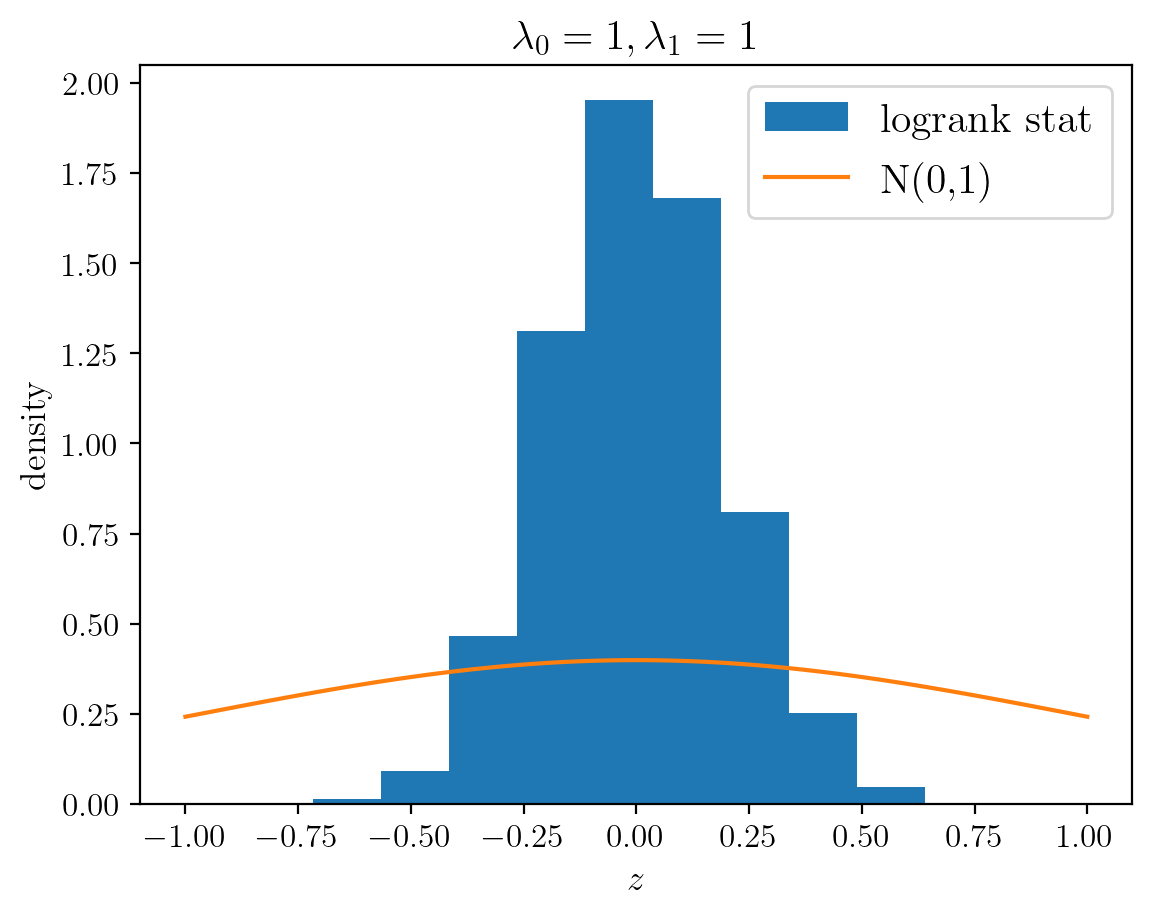

In [52]:
plt.title('$\lambda_0 = 1, \lambda_1 = 1$')
plt.hist(stats.flatten(), density=True, label='logrank stat')
xs = np.linspace(-1, 1, 100)
plt.plot(xs, scipy.stats.norm.pdf(xs), label='N(0,1)')
plt.xlabel('$z$')
plt.ylabel('density')
plt.legend()
plt.show()

In [ ]:
g = ip.cartesian_grid([0.2, 0.2], [4, 4], n=[10, 10], null_hypos=[ip.hypo("theta0 > theta1")])

In [10]:
rej_df = ip.validate(LogRank, g=g, lam=0.025, model_kwargs=dict(n=30, censoring_time=12))

(64, 2) (64, 16384, 60) (16384, 60) 12


In [11]:
rej_df

,tie_sum,tie_est,tie_cp_bound,tie_bound
0,0,0.000000,0.000281,NaN
1,0,0.000000,0.000281,NaN
2,5,0.000305,0.000800,NaN
3,175,0.010681,0.012702,NaN
4,1294,0.078979,0.084014,NaN
...,...,...,...,...
56,0,0.000000,0.000281,NaN
57,0,0.000000,0.000281,NaN
58,0,0.000000,0.000281,NaN
59,0,0.000000,0.000281,NaN


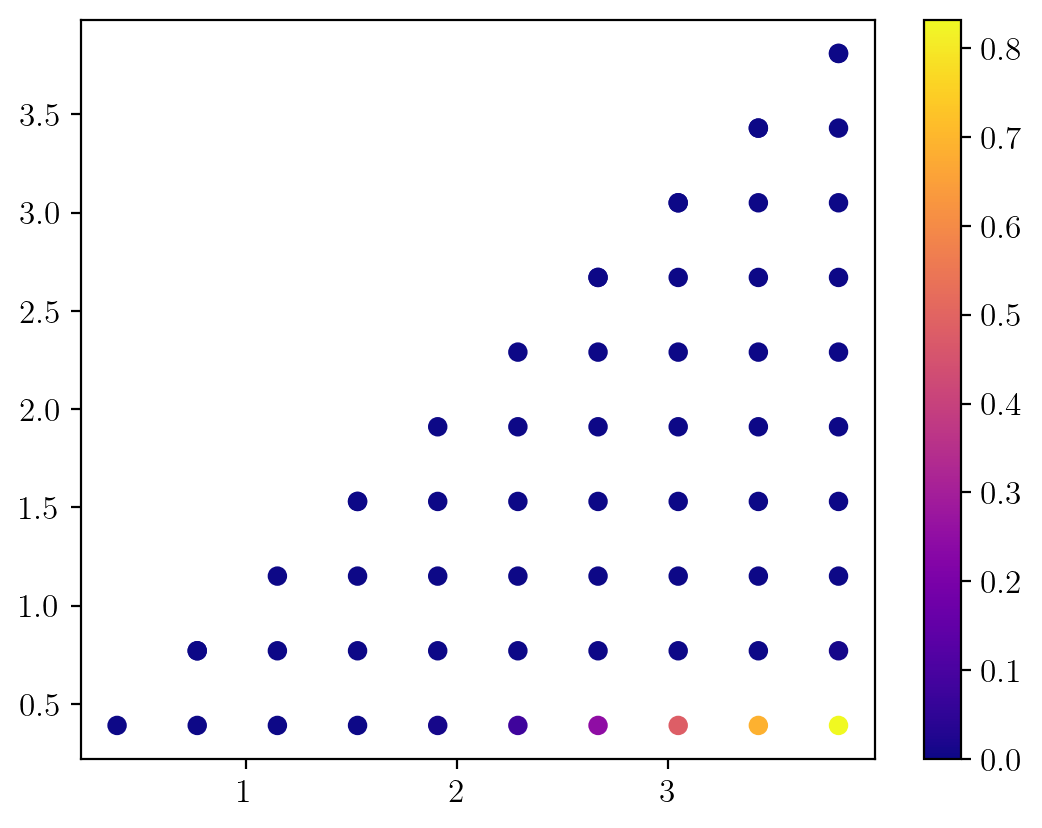

In [12]:
import matplotlib.pyplot as plt
plt.scatter(g.df['theta0'], g.df['theta1'], c=rej_df['tie_est'])
plt.colorbar()
plt.show()